## Guided Project: Credit Card Customer Segmentation

In this guided project, we're asked to help segment a credit card company’s clients into different groups in order to apply different business strategies for each type of customer.
The company expects to receive a group for each client and an explanation of the characteristics of each group and the main points that make them different.

In [187]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [188]:
#read the data into a pandas dataframe.
customers = pd.read_csv('customer_segmentation - customer_segmentation.csv')

In [189]:
#Display the first five rows of the dataframe.
customers.head()

customer_id  age gender  dependent_count education_level marital_status  \
0    768805383   45      M                3     High School        Married   
1    818770008   49      F                5        Graduate         Single   
2    713982108   51      M                3        Graduate        Married   
3    769911858   40      F                4     High School        Unknown   
4    709106358   40      M                3      Uneducated        Married   

   estimated_income  months_on_book  total_relationship_count  \
0             69000              39                         5   
1             24000              44                         6   
2             93000              36                         4   
3             37000              34                         3   
4             65000              21                         5   

   months_inactive_12_mon  credit_limit  total_trans_amount  \
0                       1       12691.0                1144   
1                       1        8256.0                1291   
2                       1        3418.0                1887   
3                       4        3313.0                1171   
4                       1        4716.0                 816   

   total_trans_count  avg_utilization_ratio  
0                 42                  0.061  
1                 33                  0.105  
2                 20                  0.000  
3                 20                  0.760  
4                 28                  0.000

In [190]:
#Print out the number of features and observations in the dataset.
customers.shape

(10127, 14)

In [191]:
# Print data types and null counts for each column.
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

There are no missing values in the data.
There are 14 columns and 10127 observations.
The customer_id column doesn't use for the analysis.  We should drop it.
There are 3 categorical columns: gender, education level, and marital status. We should change them to integers.

### Feature Engineering

In [192]:
# Create a copy of the original DataFrame.
customers_copy = customers

In [193]:
# Drop the customer_id column.
customers_copy.drop('customer_id', axis=1, inplace=True)

In [194]:
# Replace the values in the gender column with 1 for "M" and 0 for "F". 
customers_copy['gender'] = customers_copy['gender'].map(lambda x: 0 if x == 'F' else 1)

In [195]:
# Replace the values in the education_level column with continuous variables.
customers_copy['education_level'] = customers_copy['education_level'].replace({'Uneducated' : 0, 'High School' : 1, 'College' : 2, 'Graduate' : 3, 'Post-Graduate' : 4, 'Doctorate' : 5})

In [196]:
# Convert the marital_status column into dummy variables.
customers_copy = pd.get_dummies(customers_copy, columns=['marital_status'], drop_first=True)


<AxesSubplot:>

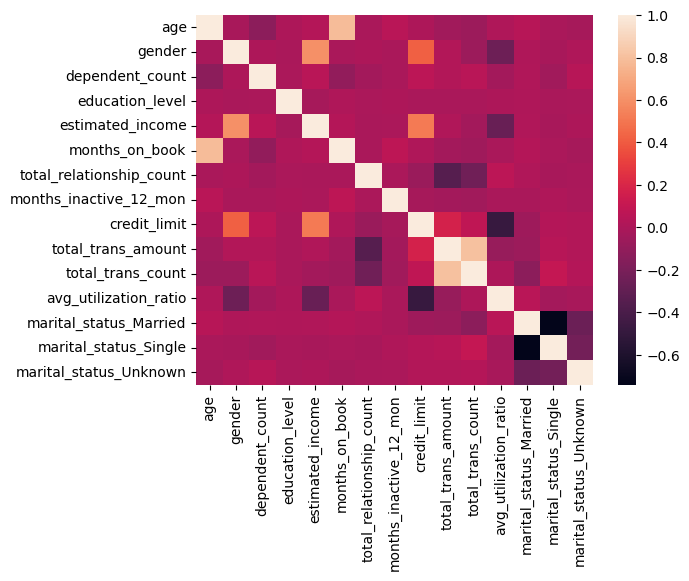

In [197]:
# Find the correlation between all the features, and create a heatmap.
correlation = customers_copy.corr()
sns.heatmap(correlation)

We can see from the heatmap that there is a high correlation between:
- gender: avg_utilization_ratio, credit_limit, estimated_income.
- age: month_on_book.
- estimated_income: avg_utilization_ratio, credit_limit, gender.
- total_relationship_count : total_trans_count, total_trans_amount.
- total_trans_amount: total_trans_count.
- credit_limit: avg_utilization_ratio, estimated_income, gender.

In [198]:
customers_copy.describe()

age        gender  dependent_count  education_level  \
count  10127.000000  10127.000000     10127.000000     10127.000000   
mean      46.325960      0.470919         2.346203         2.063197   
std        8.016814      0.499178         1.298908         1.413499   
min       26.000000      0.000000         0.000000         0.000000   
25%       41.000000      0.000000         1.000000         1.000000   
50%       46.000000      0.000000         2.000000         2.000000   
75%       52.000000      1.000000         3.000000         3.000000   
max       73.000000      1.000000         5.000000         5.000000   

       estimated_income  months_on_book  total_relationship_count  \
count      10127.000000    10127.000000              10127.000000   
mean       62078.206774       35.928409                  3.812580   
std        39372.861291        7.986416                  1.554408   
min        20000.000000       13.000000                  1.000000   
25%        32000.000000       31.000000                  3.000000   
50%        50000.000000       36.000000                  4.000000   
75%        80000.000000       40.000000                  5.000000   
max       200000.000000       56.000000                  6.000000   

       months_inactive_12_mon  credit_limit  total_trans_amount  \
count            10127.000000  10127.000000        10127.000000   
mean                 2.341167   8631.953698         4404.086304   
std                  1.010622   9088.776650         3397.129254   
min                  0.000000   1438.300000          510.000000   
25%                  2.000000   2555.000000         2155.500000   
50%                  2.000000   4549.000000         3899.000000   
75%                  3.000000  11067.500000         4741.000000   
max                  6.000000  34516.000000        18484.000000   

       total_trans_count  avg_utilization_ratio  marital_status_Married  \
count       10127.000000           10127.000000            10127.000000   
mean           64.858695               0.274894                0.462822   
std            23.472570               0.275691                0.498641   
min            10.000000               0.000000                0.000000   
25%            45.000000               0.023000                0.000000   
50%            67.000000               0.176000                0.000000   
75%            81.000000               0.503000                1.000000   
max           139.000000               0.999000                1.000000   

       marital_status_Single  marital_status_Unknown  
count           10127.000000            10127.000000  
mean                0.389355                0.073961  
std                 0.487628                0.261720  
min                 0.000000                0.000000  
25%                 0.000000                0.000000  
50%                 0.000000                0.000000  
75%                 1.000000                0.000000  
max                 1.000000                1.000000

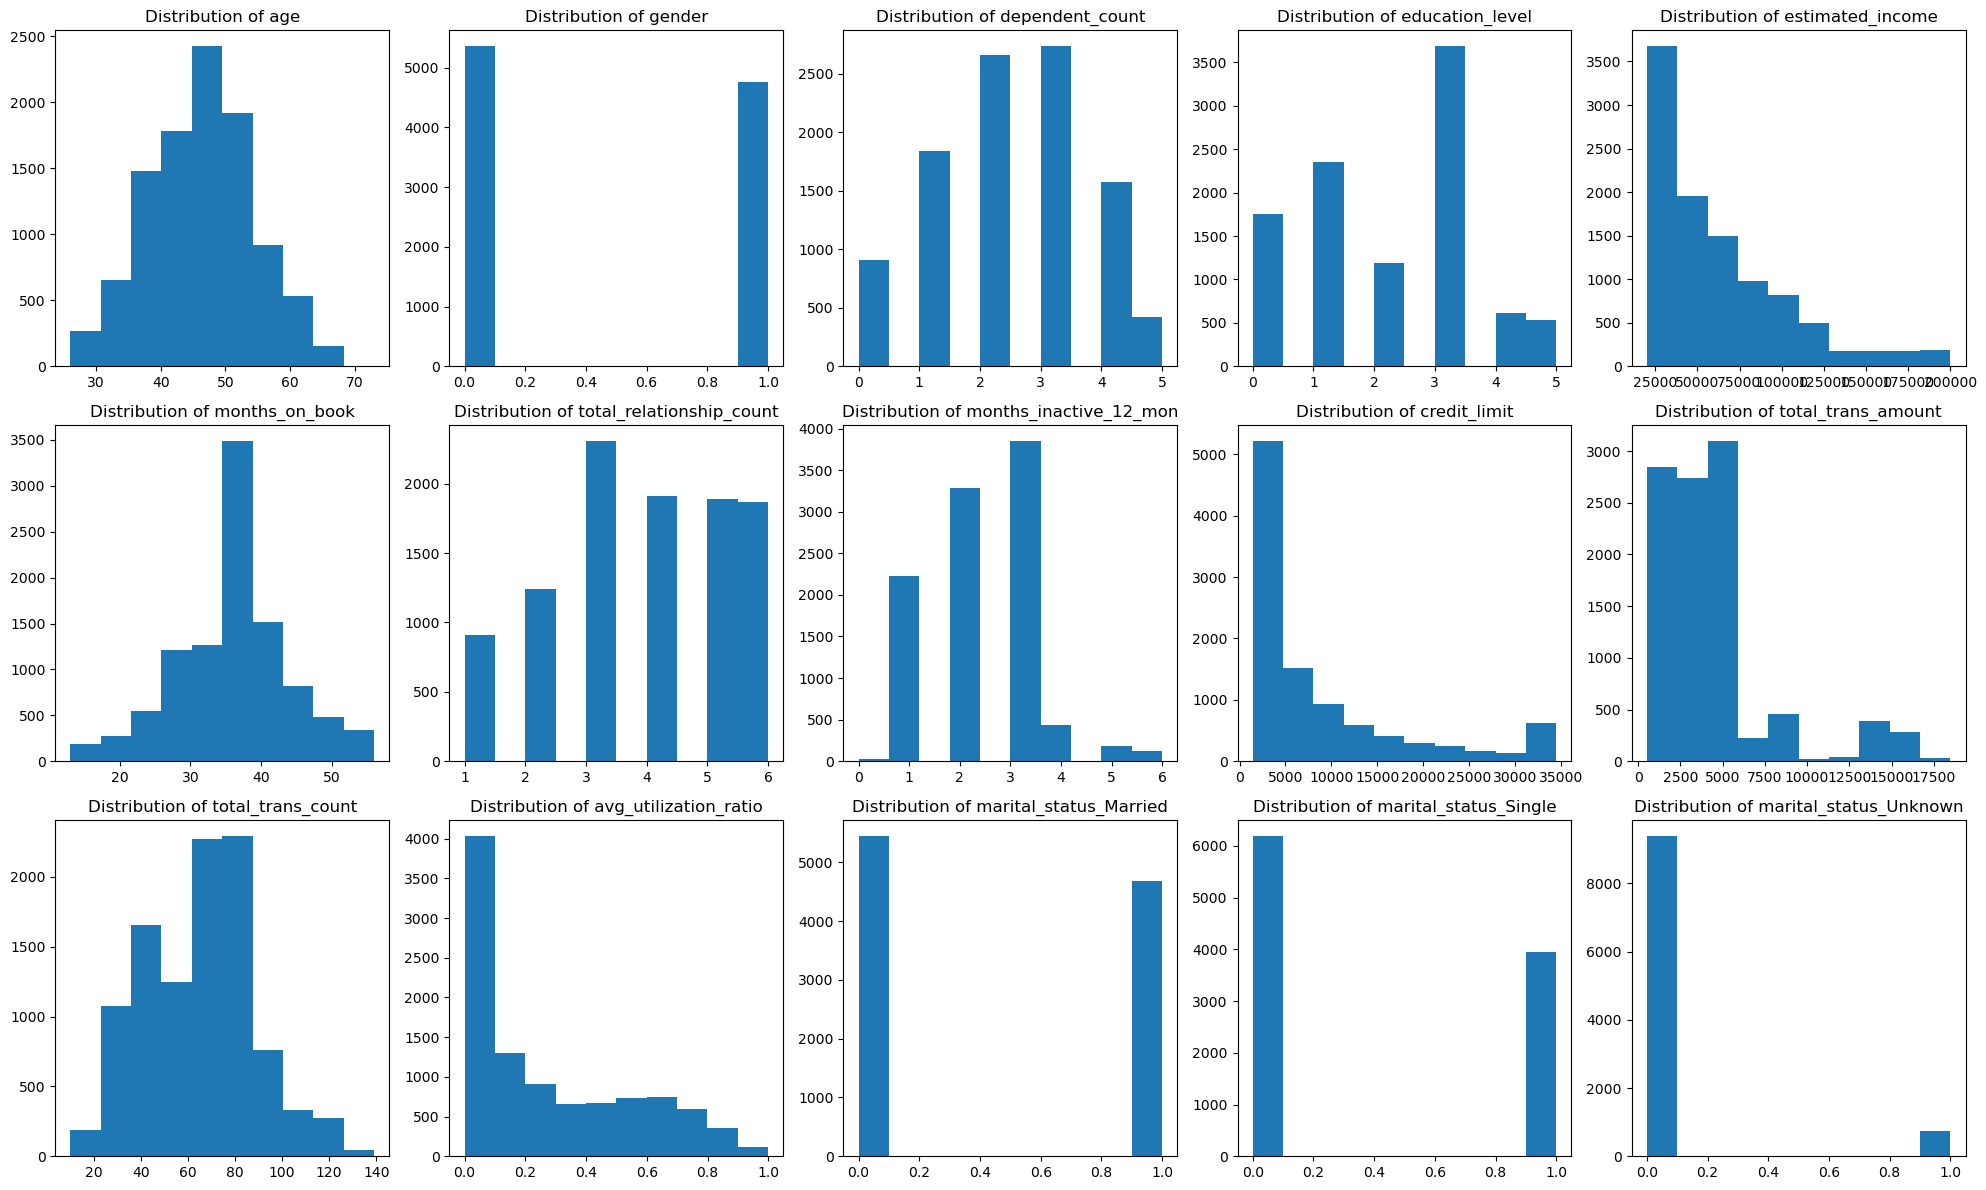

In [199]:
# Plot the distribution of each numeric column.
num_plots = len(customers_copy.columns)
num_rows = 3
num_cols = (num_plots + num_rows - 1) // num_rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4*num_cols, 4*num_rows))

for i, col in enumerate(customers_copy.columns):
    row = i // num_cols
    column = i % num_cols

    if num_rows > 1:
        ax = axes[row, column]
    else:
        ax = axes[column]

    ax.hist(customers_copy[col])
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()



From the plots we can see that:
Most of the customers' ages are between 35 and 55.
The education_level of most customers is Graduate.
The estimated_income of most of the customers is between 25000 and 50000.
The credit_limit of most of the customers is about 2000.
The tal_trans_amount of most of the customers is about 4000.
The total_trans_count of most of the customers is between 0 and 100.
The avg_utilization_ratio of most of the customers is less than 0.1.

### Scaling the Data

In [200]:
#Scale the data, and save it back to the df.
scaler = StandardScaler()
scaler.fit(customers_copy)
scaled_data = scaler.transform(customers_copy)
scaled_df = pd.DataFrame(data = scaled_data, columns=customers_copy.columns) 
scaled_df.head()

age    gender  dependent_count  education_level  estimated_income  \
0 -0.165406  1.059956         0.503368        -0.752211          0.175810   
1  0.333570 -0.943436         2.043199         0.662787         -0.967166   
2  0.583058  1.059956         0.503368         0.662787          0.785397   
3 -0.789126 -0.943436         1.273283        -0.752211         -0.636973   
4 -0.789126  1.059956         0.503368        -1.459710          0.074212   

   months_on_book  total_relationship_count  months_inactive_12_mon  \
0        0.384621                  0.763943               -1.327136   
1        1.010715                  1.407306               -1.327136   
2        0.008965                  0.120579               -1.327136   
3       -0.241473                 -0.522785                1.641478   
4       -1.869317                  0.763943               -1.327136   

   credit_limit  total_trans_amount  total_trans_count  avg_utilization_ratio  \
0      0.446622           -0.959707          -0.973895              -0.775882   
1     -0.041367           -0.916433          -1.357340              -0.616276   
2     -0.573698           -0.740982          -1.911206              -0.997155   
3     -0.585251           -0.951758          -1.911206               1.759686   
4     -0.430877           -1.056263          -1.570365              -0.997155   

   marital_status_Married  marital_status_Single  marital_status_Unknown  
0                1.077338              -0.798507               -0.282609  
1               -0.928214               1.252337               -0.282609  
2                1.077338              -0.798507               -0.282609  
3               -0.928214              -0.798507                3.538459  
4                1.077338              -0.798507               -0.282609

### Choosing K

In [201]:
# Create several models and compute the inertia from each of them.
inertias= []
kmax = 10
for k in range(2, kmax+1):
    kmeans= KMeans(n_clusters=k).fit(scaled_df)
    inertias.append(kmeans.inertia_)

print(inertias)

[134790.38893921167, 123153.57204573852, 112889.3014506777, 104078.94049240722, 98723.49899833533, 94452.49910879922, 91000.74585019448, 88400.66086492228, 86161.76737384983]


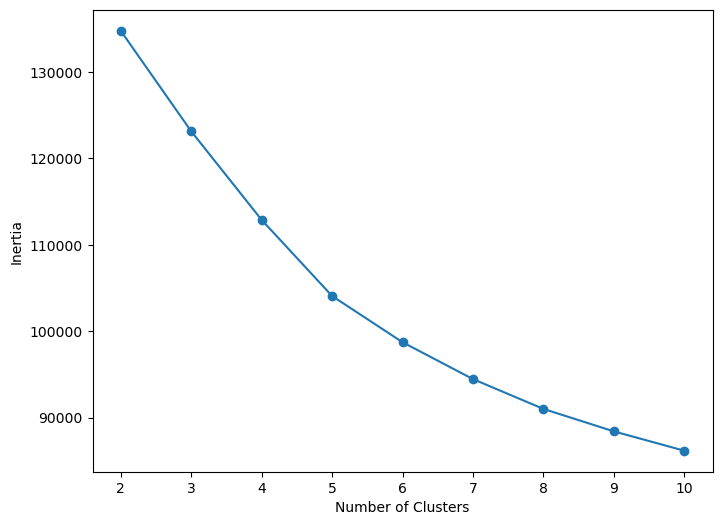

In [202]:
# Plot the Elbow Curve.
plt.figure(figsize=(8,6))
plt.plot(np.arange(2, 11), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

From the slope of the graph you can see that we should have 5 clusters in the model.

In [203]:
# Instantiate a Kmeans object, with the decided number of clusters as K.
kmeans = KMeans(n_clusters=5)

In [204]:
# 'fit_predict' the data and print the outcome.
predictions = kmeans.fit_predict(scaled_df)
print(predictions)

[1 2 1 ... 0 4 0]


### Analyzing Results

In [205]:
# Create a new column called CLUSTER in the df with the cluster assigned to each customer by the algorithm.
customers_copy['CLUSTER'] = predictions

In [206]:
# Group the data by the cluster column.
grouped_data =  customers_copy.groupby('CLUSTER').mean()
grouped_data

age    gender  dependent_count  education_level  \
CLUSTER                                                          
0        46.914518  0.271805         2.314402         2.101420   
1        46.834913  0.966085         2.528678         2.035411   
2        45.800269  0.306164         2.212866         2.061300   
3        45.333333  0.650052         2.335410         1.994808   
4        45.602165  0.485792         2.549391         2.056834   

         estimated_income  months_on_book  total_relationship_count  \
CLUSTER                                                               
0            45040.278180       36.452622                  4.020284   
1           111180.049875       36.293766                  4.097756   
2            46474.570562       35.497137                  3.923206   
3            69394.600208       35.164071                  2.156802   
4            61577.807848       35.217862                  3.782138   

         months_inactive_12_mon  credit_limit  total_trans_amount  \
CLUSTER                                                             
0                      2.343669   4056.450188         3273.505071   
1                      2.355611  18820.138653         3157.547132   
2                      2.379926   4957.055035         3742.910408   
3                      2.190031  14645.377985        12957.161994   
4                      2.331529   9284.996076         4576.435724   

         total_trans_count  avg_utilization_ratio  marital_status_Married  \
CLUSTER                                                                     
0                58.149812               0.379970                0.912489   
1                55.685287               0.082090                0.539152   
2                65.305490               0.322616                0.000000   
3               105.391485               0.165227                0.474559   
4                66.462788               0.258486                0.000000   

         marital_status_Single  marital_status_Unknown  
CLUSTER                                                 
0                     0.000000                0.000000  
1                     0.345137                0.000000  
2                     0.957898                0.000000  
3                     0.422638                0.010384  
4                     0.000000                1.000000

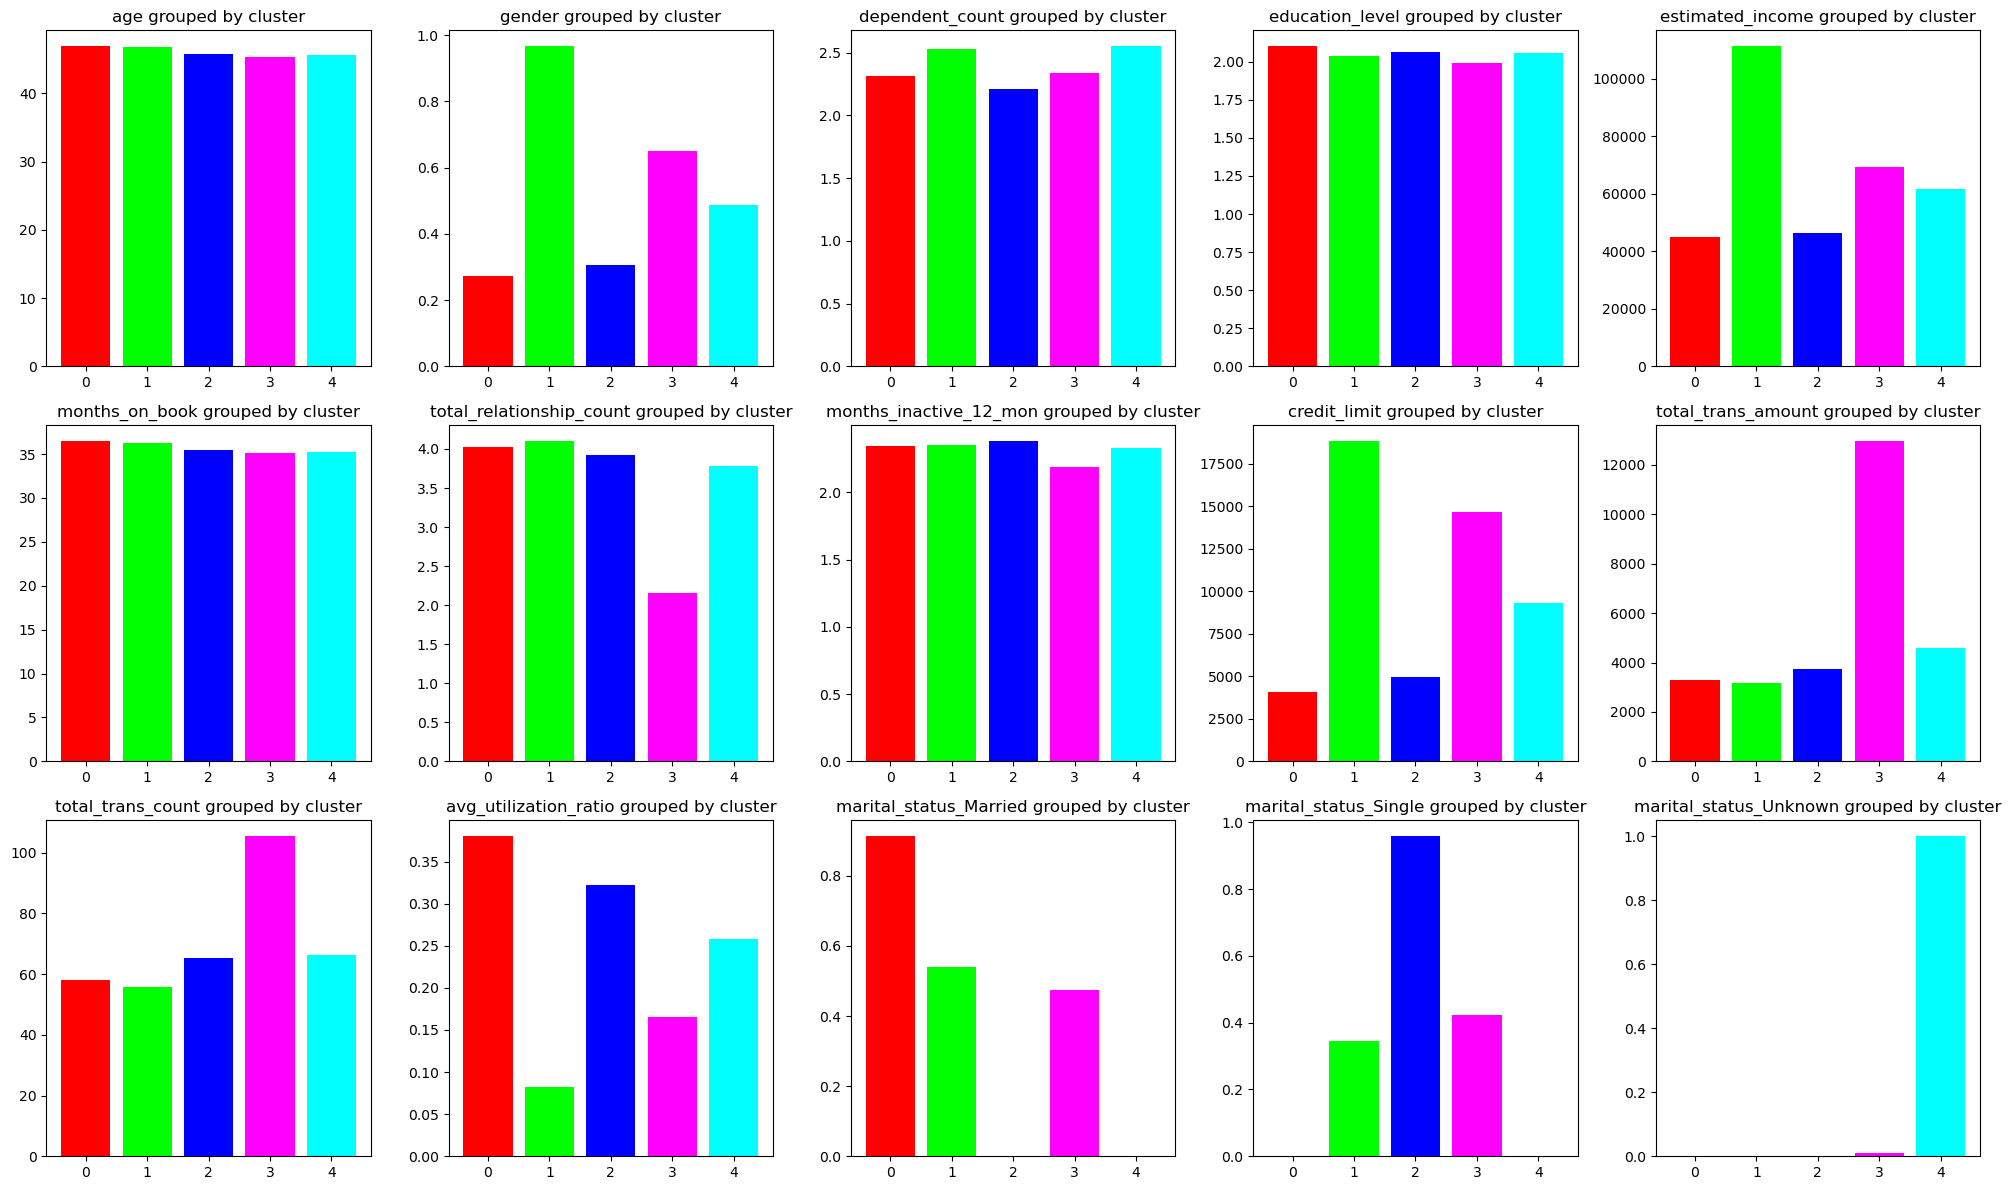

In [207]:
# Plot a bar chart for each grouped column.
num_plots = len(grouped_data.columns)
num_rows = 3
num_cols = (num_plots + num_rows - 1) // num_rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4*num_cols, 4*num_rows))

for i, col in enumerate(grouped_data.columns):
    row = i // num_cols
    column = i % num_cols

    if num_rows > 1:
        ax = axes[row, column]
    else:
        ax = axes[column]

    ax.bar(grouped_data.index, grouped_data[col], color=['#FF0000', '#00FF00', '#0000FF', '#FF00FF', '#00FFFF'])
    ax.set_title(f'{col} grouped by cluster')

plt.tight_layout()
plt.show()

We see from the bar plots that:
The age, education_level, month_on_book, month_in_active_12_mon, and dependent_count are almost the same in all the clusters, meaning that the clusters were not divided according to these columns.
The gender, avg_utilization_ratio, credit_limit, and estimated_income are different in each cluster, which means that the clusters are divided according to these columns.
The total_relationship_count is different in cluster 0, meaning that the division considers this column.
The total_trans_amount and total_trans_count are different in cluster 0, which means that the division takes in mind these columns.
The marital_status appears only in a few clusters, which means that the division takes into mind these columns.

Text(0.5, 0.98, 'pairplot of customers data')

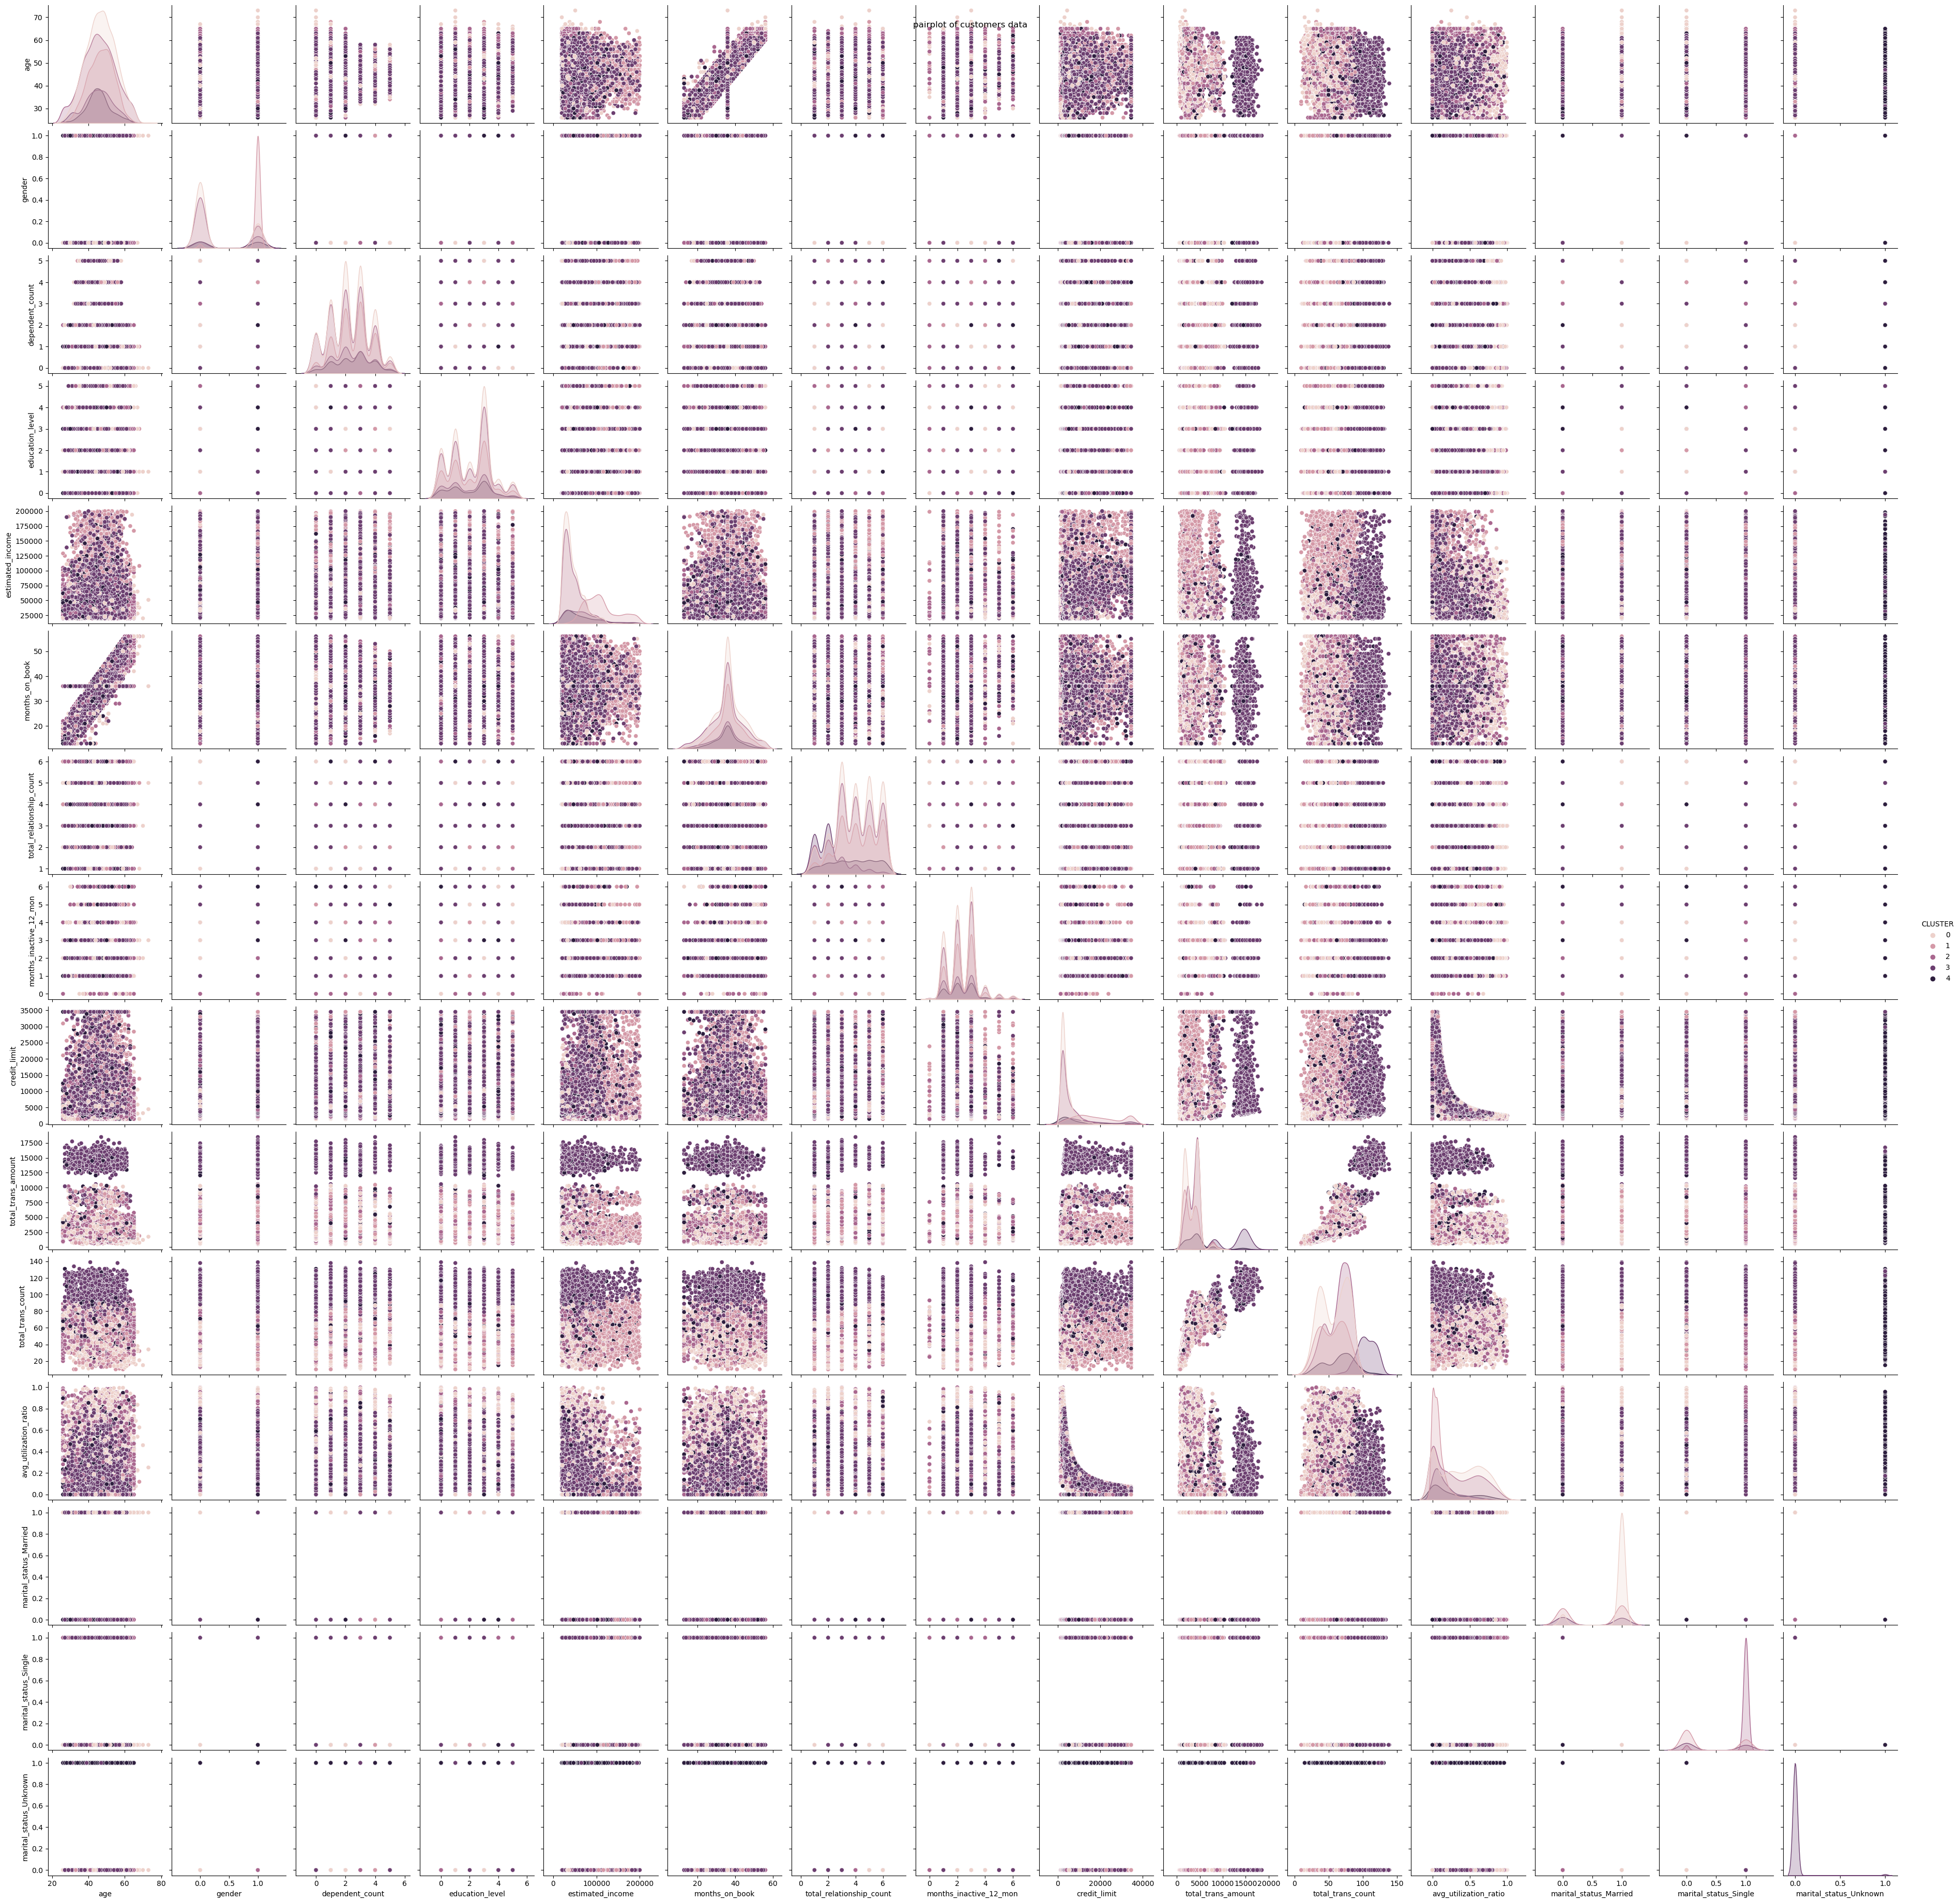

In [208]:
# Create a pairplot in order to find the correlated features.
sns.pairplot(customers_copy,hue='CLUSTER')
plt.suptitle('pairplot of customers data')

Text(0.5, 0.98, 'Scatter plot of age and months_on_book columns colored by the clusters')

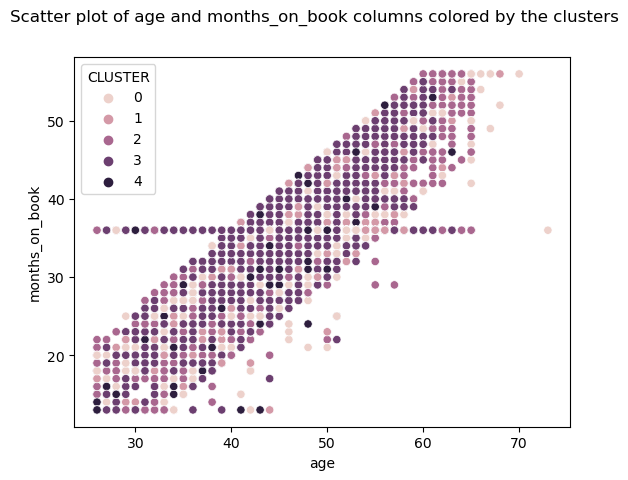

In [209]:
# Plot a scatter plot colored by the clusters for the age and month_on_book columns.
sns.scatterplot(data= customers_copy, x='age', y='months_on_book', hue='CLUSTER')
plt.suptitle('Scatter plot of age and months_on_book columns colored by the clusters')

The clusters are not ordered in the scatter plot, meaning that the clusters are not divided according to these columns.

Text(0.5, 0.98, 'Scatter plot of credit_limit and avg_utilization_ratio columns colored by the clusters')

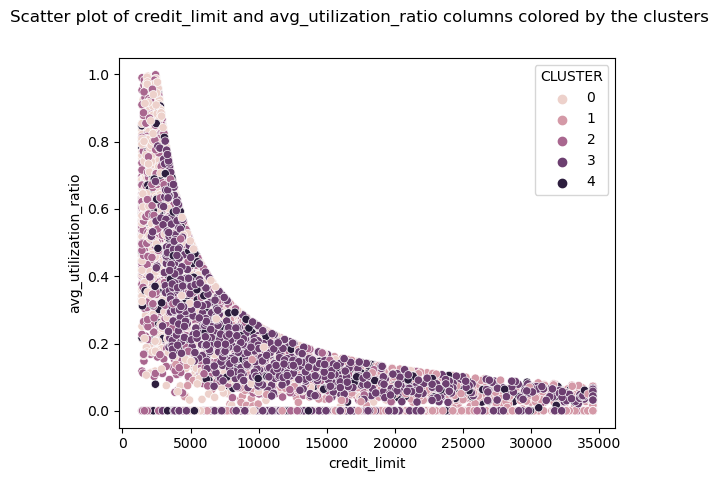

In [210]:
# Plot a scatter plot colored by the clusters for the credit_limit and avg_utilization_ratio columns.
sns.scatterplot(data= customers_copy, x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER')
plt.suptitle('Scatter plot of credit_limit and avg_utilization_ratio columns colored by the clusters')

The clusters are not ordered in the scatter plot, but we can see that clusrers 0 and 1 have low credit limit.

Text(0.5, 0.98, 'Scatter plot of total_trans_count and total_trans_amount columns colored by the clusters')

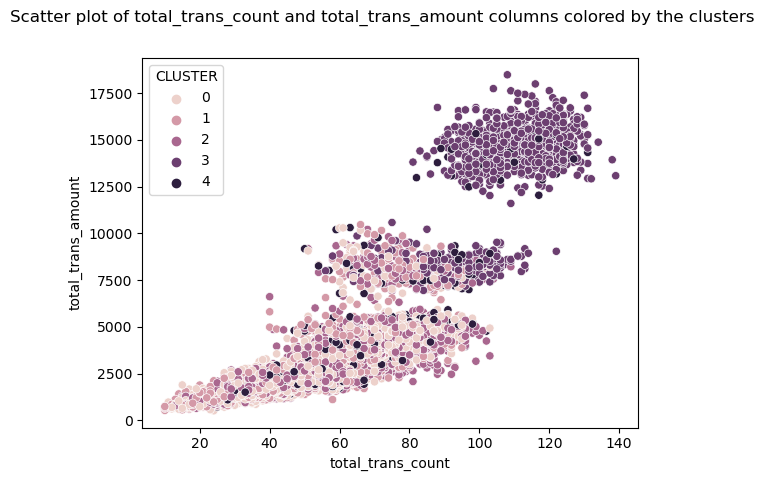

In [211]:
# Plot a scatter plot colored by the clusters for the total_trans_count and total_trans_amount columns.
sns.scatterplot(data= customers_copy, x='total_trans_count', y='total_trans_amount', hue='CLUSTER')
plt.suptitle('Scatter plot of total_trans_count and total_trans_amount columns colored by the clusters')

We see from the scatter plot that cluster 3 and 4 have high total_trans_count/amount. and clusters 0, 1  and 2 have high total_trans_count/amount.

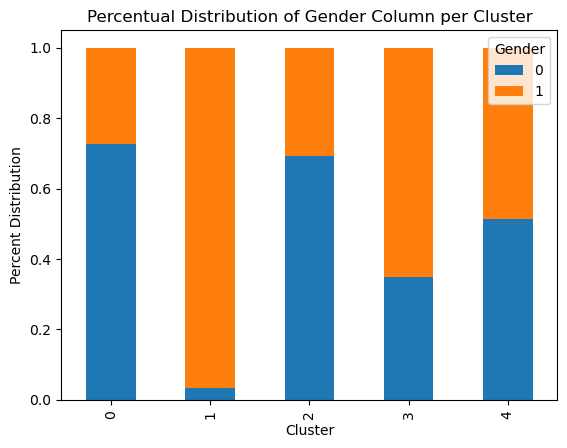

In [215]:
# Calculate the percentual distribution of each variable per cluster for the gender column and plot a stacked bar chart.
cross_tab = pd.crosstab(customers_copy['CLUSTER'], customers_copy['gender'])
percent_distribution = cross_tab.div(cross_tab.sum(1), axis=0)
percent_distribution.plot(kind='bar', stacked=True)
plt.legend(title='Gender')
plt.xlabel('Cluster')
plt.ylabel('Percent Distribution')
plt.title('Percentual Distribution of Gender Column per Cluster')
plt.show()


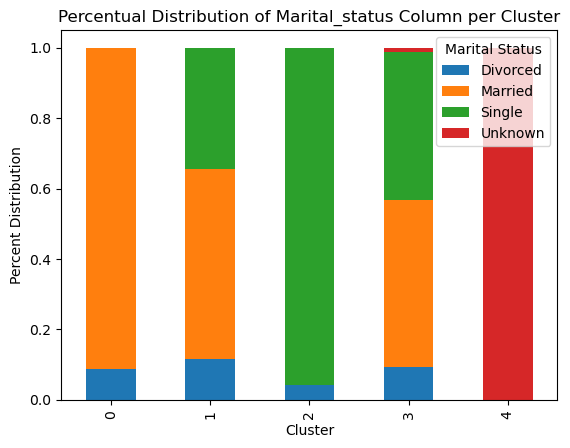

In [221]:
# Calculate the percentual distribution of each variable per cluster for the marital_status column and plot a stacked bar chart.
customers_copy2 = customers
customers_copy2['CLUSTER'] = predictions

cross_tab = pd.crosstab(customers_copy2['CLUSTER'], customers_copy2['marital_status'])
percent_distribution = cross_tab.div(cross_tab.sum(1), axis=0)
percent_distribution.plot(kind='bar', stacked=True)
plt.legend(title='Marital Status')
plt.xlabel('Cluster')
plt.ylabel('Percent Distribution')
plt.title('Percentual Distribution of Marital_status Column per Cluster')
plt.show()

### Conclusions

* **Cluster 0:** This cluster is made up of married women with an average income of $40,000. They have a credit limit of $4,000 and an average utilization ratio of 0.4.

Analysis: Cluster 0 is likely made up of young married couples who are just starting out. They have a low income and a high utilization ratio, which suggests that they are still in the process of building their credit.

Conclusion: This cluster may be a good target for credit card companies that offer introductory APRs or sign-up bonuses. These offers can help young couples build their credit and save money on interest.

* **Cluster 1:** This cluster is made up of single women with an average income of over $100,000. They have a credit limit of $18,000 and an average utilization ratio of 0.09.

Analysis: Cluster 1 is likely made up of more established professionals. They have a high income and a low utilization ratio, which suggests that they are good credit risks.

Conclusion: This cluster may be a good target for credit card companies that offer rewards programs or travel benefits. These offers can help these professionals save money and earn rewards on their everyday spending.

* **Cluster 2:** This cluster is made up of single men with an average income of $50,000. They have a credit limit of $5,000 and an average utilization ratio of 0.3.

Analysis: Cluster 2 is likely made up of single young adults who are just starting to build their credit. They have a low income and a moderate utilization ratio, which suggests that they are still in the process of building their credit.

Conclusion: This cluster may be a good target for credit card companies that offer introductory APRs or sign-up bonuses. These offers can help young adults build their credit and save money on interest.

* **Cluster 3:** This cluster is made up of married and single women with an average income of $70,000. They have a credit limit of $15,000 and an average utilization ratio of 0.15.

Analysis: Cluster 3 is likely made up of more established professionals. They have a high income and a low utilization ratio, which suggests that they are good credit risks.

Conclusion: This cluster may be a good target for credit card companies that offer rewards programs or travel benefits. These offers can help these professionals save money and earn rewards on their everyday spending.

* **Cluster 4:** This cluster is made up of a mix of men and women with an average income of $60,000. They have a credit limit of $10,000 and an average utilization ratio of 0.25.

Analysis: Cluster 4 is likely made up of people who are in the middle of their careers. They have a moderate income and a moderate utilization ratio, which suggests that they are managing their credit well.

Conclusion: This cluster may be a good target for credit card companies that offer a variety of benefits, such as rewards programs, travel benefits, and introductory APRs. These offers can help people in this cluster save money and earn rewards on their everyday spending.

In conclusion, the four clusters represent different types of customers. These clusters can be used to segment customers for marketing and other purposes.